# Another version: Feature Selection 후에 그리드서치CV

## 01-1. import와 모델링 전 컬럼 전처리

In [32]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression

from model import *

from sklearn.model_selection import learning_curve

In [33]:
# 데이터 불러오기
df = pd.read_excel('../data/file/ml_all.xlsx', index_col=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 601 entries, 0 to 600
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   korean_title                  601 non-null    object 
 1   english_title                 601 non-null    object 
 2   year                          601 non-null    int64  
 3   total_season_num              601 non-null    int64  
 4   runtime                       601 non-null    int64  
 5   genre                         601 non-null    object 
 6   age_rating                    601 non-null    int64  
 7   production_country            601 non-null    object 
 8   PCA                           601 non-null    float64
 9   genre_len                     601 non-null    int64  
 10  production_country_freq_code  601 non-null    int64  
 11  production_country_code       601 non-null    int64  
 12  seson_n                       601 non-null    int64  
 13  i_s1_rate 

In [34]:
# 각 범주(나라)의 타겟 변수(여기서는 runtime의 평균) 계산
country_means = df.groupby('production_country')['PCA'].mean()

# 타겟 인코딩 적용
df['production_country_encoded'] = df['production_country'].map(country_means)

In [35]:
# 넷플릭스 장르 선호도 순위 리스트 (선호도 순서대로 정렬)
genres = [
    '드라마', '코미디', 'SF', '액션', '스릴러', '범죄', '공포', '로맨스', '판타지', '전쟁', '서부', '그 외'
]

# 각 장르에 점수를 선형적으로 할당하여 딕셔너리로 만들기
genre_scores = {genre: 1 - i / (len(genres)) for i, genre in enumerate(genres)}

# '그 외'에 해당되는 장르 리스트
other_genres = ['역사', '가족', '음악', 'Made in Europe', '스포츠']

# 장르 문자열을 받아서 점수를 계산하는 함수

def get_genre_score(genre_str):
    # 장르를 ', '로 분리
    genre_list = genre_str.split(', ')
    
    # '그 외'에 포함된 하위 장르가 있는지 확인
    for genre in genre_list:
        if genre in other_genres:
            return genre_scores['그 외']
    
    # 각 장르의 점수의 평균 계산
    total_score = 0
    count = 0
    for genre in genre_list:
        score = genre_scores.get(genre, genre_scores['그 외'])  # 없는 장르는 '그 외' 점수로 처리
        total_score += score
        count += 1
    
    # 평균 점수 계산
    average_score = total_score / count if count > 0 else 0
    return average_score

# 장르별 점수
df['genre'] = df['genre'].apply(get_genre_score)

In [36]:
# 로그 변환 적용 

df['i_s2_rate_cnt'] = np.log1p(df['i_s2_rate_cnt'])  # log(1+x) 변환 사용
df['w_s2_rate_cnt'] = np.log1p(df['w_s2_rate_cnt'])
df['s2_rate_cnt_retention'] = np.log1p(df['s2_rate_cnt_retention'])
df['s1_gap_days'] = np.log1p(df['s1_gap_days'])
df['age_rating'] = np.log1p(df['age_rating'])
df['season_gaps_days'] = np.log1p(df['season_gaps_days'])
df['i_s1_rate_cnt'] = np.log1p(df['i_s1_rate_cnt'])  # log(1+x) 변환 사용
df['w_s1_rate_cnt'] = np.log1p(df['w_s1_rate_cnt'])
df['s1_rate_cnt_retention'] = np.log1p(df['s1_rate_cnt_retention'])

In [37]:
# y값(흥행도)

# 각 요소 계산
rate = (0.8 * df['i_s2_rate']) + (0.2 * df['w_s2_rate'])
cnt = (0.8 * df['i_s2_rate_cnt']) + (0.2 * df['w_s2_rate_cnt'])
ret = (0.4 * df['s2_rate_retention']) + (0.6 * df['s2_rate_cnt_retention'])

# 총 점수 계산
total = (0.3 * rate + 0.5 * cnt + 0.2 * ret) *10

# 점수를 데이터프레임에 추가
df['score'] = total

---

## 01-2. 각 모델의 Feature Selection과 결과

In [38]:
df = df[['runtime','genre','age_rating','production_country_encoded','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days','score']]

In [39]:
X = df.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [40]:
# 사용할 모델 리스트
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=13),
    'RandomForestRegressor': RandomForestRegressor(random_state=13),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(random_state=13),
    'AdaBoostRegressor': AdaBoostRegressor(random_state=13),
    'LGBMRegressor': LGBMRegressor(random_state=13),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=13),
    'LinearRegression': LinearRegression()
}

# 후진 제거 피처 셀렉션 함수
def backward_elimination(model, X_train, y_train, X_test, y_test):
    features = X_train.columns.tolist()
    best_mse = mean_squared_error(y_test, model.fit(X_train, y_train).predict(X_test))
    best_features = features.copy()

    for feature in features:
        temp_features = best_features.copy()
        temp_features.remove(feature)
        
        X_train_temp, X_test_temp = X_train[temp_features], X_test[temp_features]
        model.fit(X_train_temp, y_train)
        mse = mean_squared_error(y_test, model.predict(X_test_temp))
        
        if mse <= best_mse:
            best_mse = mse
            best_features = temp_features

    print(f"Best MSE: {best_mse}")
    print(f"Selected Features: {best_features}")
    print("="*40)
    return best_mse, best_features

# 모든 모델에 대해 후진 제거 피처 셀렉션 수행
results = {}

for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")
    best_mse, best_features = backward_elimination(model, X_train, y_train, X_test, y_test)
    results[model_name] = {
        'best_mse': best_mse,
        'best_features': best_features
    }

Evaluating model: DecisionTreeRegressor
Best MSE: 7.265496539016362
Selected Features: ['genre', 'production_country_encoded', 'genre_len', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_retention', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
Evaluating model: RandomForestRegressor
Best MSE: 3.898729281167659
Selected Features: ['genre', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
Evaluating model: KNeighborsRegressor
Best MSE: 5.168722174790508
Selected Features: ['genre', 'age_rating', 'production_country_encoded', 'genre_len', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_retention', 'w_s1_rate', 'w_s1_rate_cnt']
Evaluating model: XGBRegressor
Best MSE: 4.589866698731341
Selected Features: ['runtime', 'age_rating', 'production_country_encoded', 'genre_len', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_retention', 's1_rate_cnt_retent

In [41]:
# 결과 출력
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best MSE: {result['best_mse']}")
    print(f"Selected Features: {result['best_features']}")
    print("="*40)

Model: DecisionTreeRegressor
Best MSE: 7.265496539016362
Selected Features: ['genre', 'production_country_encoded', 'genre_len', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_retention', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
Model: RandomForestRegressor
Best MSE: 3.898729281167659
Selected Features: ['genre', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
Model: KNeighborsRegressor
Best MSE: 5.168722174790508
Selected Features: ['genre', 'age_rating', 'production_country_encoded', 'genre_len', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_retention', 'w_s1_rate', 'w_s1_rate_cnt']
Model: XGBRegressor
Best MSE: 4.589866698731341
Selected Features: ['runtime', 'age_rating', 'production_country_encoded', 'genre_len', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_retention', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_

## 02-1. GridSearchCV('model.py'이용) 모델링

In [42]:
# 특정 모델에 대해 선택된 피처로 그리드 서치 및 평가
model_name = "DecisionTreeRegressor"
best_features = results[model_name]['best_features']
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]
best_dt, best_params_dt = grid_search(X_train_selected, y_train, model_name)
dt_mae, dt_mse, dt_r2 = evaluate(best_dt, X_test_selected, y_test)
print(best_dt, best_params_dt)

MAE: 2.329253509064157
MSE: 9.996459088556557
R^2: 0.884604487157874
DecisionTreeRegressor(max_depth=7, min_samples_split=10, random_state=13) {'max_depth': 7, 'min_samples_split': 10}


{'runtime': 0.0, 'genre': 0.001263319339401012, 'age_rating': 0.0008114902347687884, 'production_country_encoded': 0.0006719758411513716, 'genre_len': 0.029530468163745306, 'seson_n': 0.888886315037594, 'i_s1_rate': 0.0018958196449679566, 'i_s1_rate_cnt': 0.00025891210712262406, 's1_rate_retention': 0.008635541782987146, 's1_rate_cnt_retention': 0.06447464182460001, 'w_s1_rate': 0.0007613867017199424, 'w_s1_rate_cnt': 0.0028101293219417994}


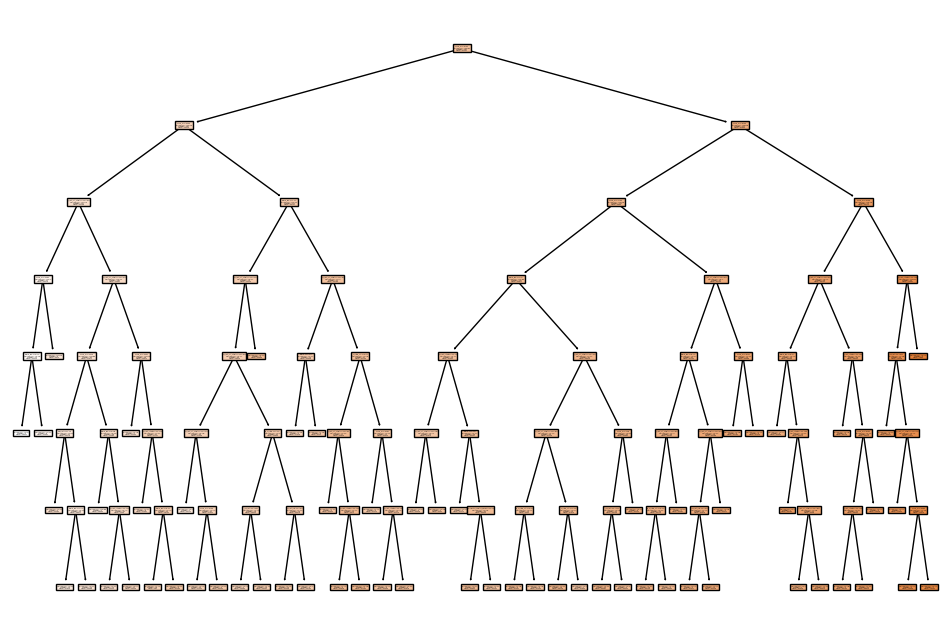

In [43]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 특성 중요도를 확인합니다
feature_importances_dt = best_dt.feature_importances_
importances_dict = dict(zip(X_train.columns, feature_importances_dt))
print(importances_dict)

# 결정 트리를 시각화합니다
plt.figure(figsize=(12, 8))
plot_tree(best_dt, filled=True, feature_names=X.columns.tolist())
plt.show()

In [44]:
# 특정 모델에 대해 선택된 피처로 그리드 서치 및 평가
model_name = "RandomForestRegressor"
best_features = results[model_name]['best_features']
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]
best_rf, best_params_rf = grid_search(X_train_selected, y_train, model_name)
rf_mae, rf_mse , rf_r2 = evaluate(best_rf, X_test_selected, y_test)
print(best_rf, best_params_rf)

MAE: 1.5033862951175794
MSE: 4.012174981614105
R^2: 0.9536849012721204
RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=300,
                      random_state=13) {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}


In [45]:
# 특정 모델에 대해 선택된 피처로 그리드 서치 및 평가
model_name = "KNeighborsRegressor"
best_features = results[model_name]['best_features']
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]
best_knn, best_params_knn = grid_search(X_train_selected, y_train, model_name)
knn_mae, knn_mse , knn_r2 = evaluate(best_knn, X_test_selected, y_test)
print(best_knn, best_params_knn)

MAE: 1.621495580367991
MSE: 4.439313682119964
R^2: 0.9487541664026087
KNeighborsRegressor(n_neighbors=10, weights='distance') {'n_neighbors': 10, 'weights': 'distance'}


In [46]:
# 특정 모델에 대해 선택된 피처로 그리드 서치 및 평가
model_name = "XGBRegressor"
best_features = results[model_name]['best_features']
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]
best_xgb, best_params_xgb = grid_search(X_train_selected, y_train, model_name)
xgb_mae, xgb_mse, xgb_r2 = evaluate(best_xgb, X_test_selected, y_test)
print(best_xgb, best_params_xgb)

MAE: 1.3947551322827099
MSE: 3.346868089236422
R^2: 0.961364963718553
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=13, ...) {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [47]:
# 특정 모델에 대해 선택된 피처로 그리드 서치 및 평가
model_name = "AdaBoostRegressor"
best_features = results[model_name]['best_features']
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]
best_ada, best_params_ada = grid_search(X_train_selected, y_train, model_name)
ada_mae, ada_mse, ada_r2 = evaluate(best_ada, X_test_selected, y_test)
print(best_ada, best_params_ada)

MAE: 1.9275189860248014
MSE: 5.9794119996840935
R^2: 0.9309758277320634
AdaBoostRegressor(learning_rate=0.2, n_estimators=200, random_state=13) {'learning_rate': 0.2, 'n_estimators': 200}


In [48]:
# 특정 모델에 대해 선택된 피처로 그리드 서치 및 평가
model_name = "LGBMRegressor"
best_features = results[model_name]['best_features']
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]
best_lgb, best_params_lgb = grid_search(X_train_selected, y_train, model_name)
lgb_mae, lgb_mse, lgb_r2 = evaluate(best_lgb, X_test_selected, y_test)
print(best_lgb, best_params_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 14
[LightGBM] [Info] Start training from score 54.253274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [49]:
print(best_lgb, best_params_lgb)

LGBMRegressor(learning_rate=0.05, max_depth=5, random_state=13) {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


In [50]:
# 특정 모델에 대해 선택된 피처로 그리드 서치 및 평가
model_name = "GradientBoostingRegressor"
best_features = results[model_name]['best_features']
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]
best_gbr, best_params_gbr = grid_search(X_train_selected, y_train, model_name)
gbr_mae, gbr_mse, gbr_r2 = evaluate(best_gbr, X_test_selected, y_test)
print(best_gbr, best_params_gbr)

MAE: 1.335346176512164
MSE: 3.0533176724718953
R^2: 0.9647536036947162
GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=13) {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


{'genre': 0.0015252617980306292, 'production_country_encoded': 0.004561522354841478, 'genre_len': 0.0007911441981496375, 'seson_n': 0.0003947564427587858, 'i_s1_rate': 0.031178126340819082, 'i_s1_rate_cnt': 0.8463996111238123, 's1_rate_retention': 0.0020298223341383165, 's1_rate_cnt_retention': 0.002316463524460592, 'w_s1_rate': 0.021740006726519157, 'w_s1_rate_cnt': 0.08635703412489511, 'season_gaps_days': 0.002706251031575002}


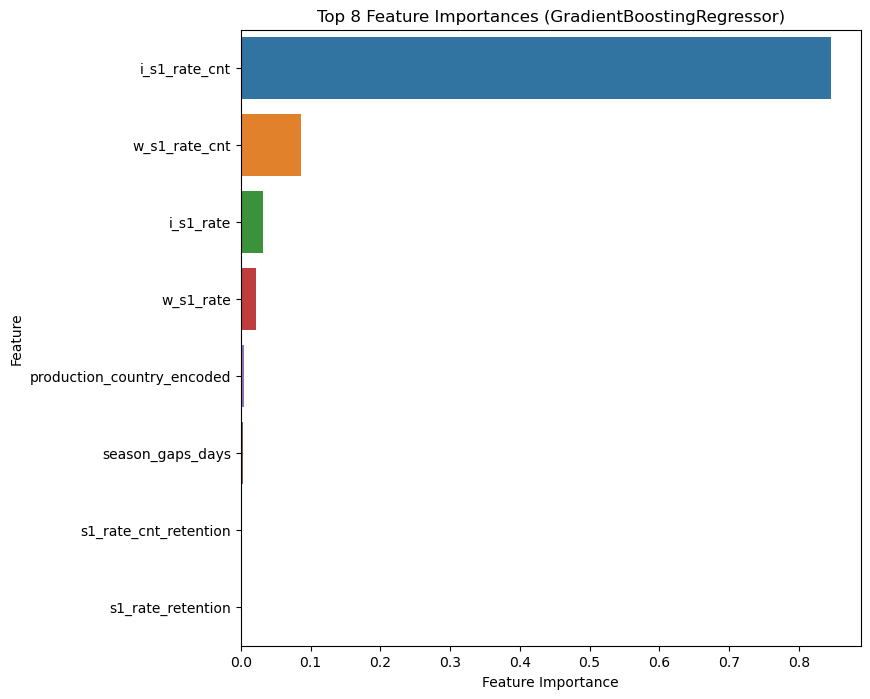

In [51]:
# 특성 중요도 확인
feature_importances_gbr = best_gbr.feature_importances_
importances_dict_gbr = dict(zip(X_train_selected.columns, feature_importances_gbr))
print(importances_dict_gbr)

# 중요도가 높은 상위 8개의 컬럼 선택
best_cols_gbr = pd.Series(feature_importances_gbr, index=X_train_selected.columns)
top_cols_gbr = best_cols_gbr.sort_values(ascending=False)[:8]

# 시각화
plt.figure(figsize=(8, 8))
sns.barplot(x=top_cols_gbr, y=top_cols_gbr.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 8 Feature Importances (GradientBoostingRegressor)')
plt.show()

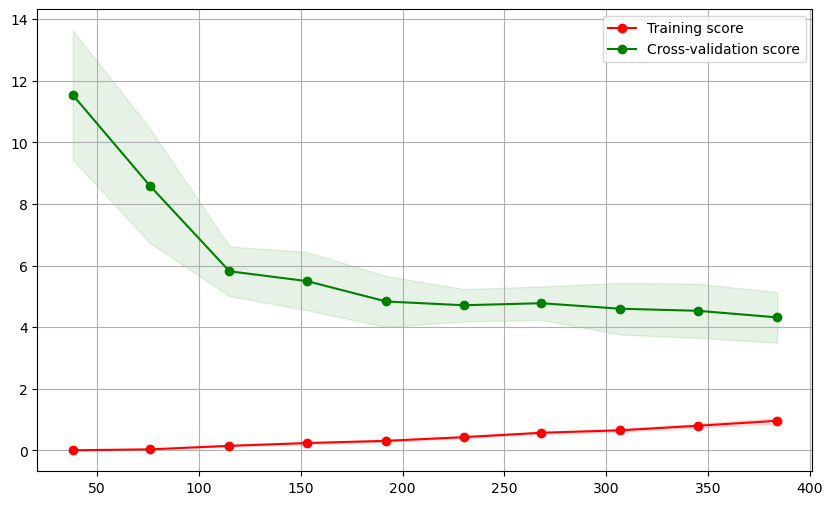

In [52]:
# learning curve 계산
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    best_gbr, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), return_times=True
)

# 성능 지표 계산
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.legend(loc="best")
plt.grid()
plt.show()

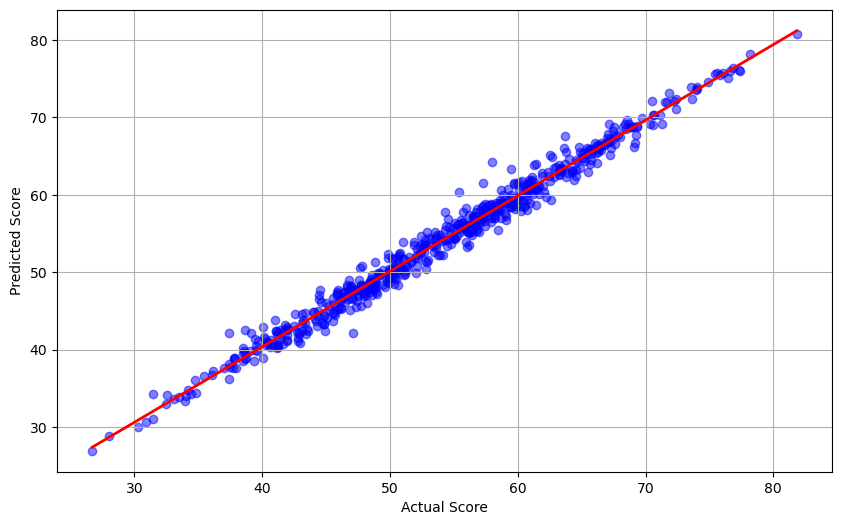

In [53]:
# 예측값 계산
y_train_pred = best_gbr.predict(X_train[best_features])
y_test_pred = best_gbr.predict(X_test[best_features])

# 훈련 데이터와 테스트 데이터를 합친 전체 데이터셋
X_combined = np.vstack((X_train[best_features], X_test[best_features]))
y_combined = np.concatenate((y_train, y_test))
y_combined_pred = np.concatenate((y_train_pred, y_test_pred))

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_combined, y_combined_pred, color='blue', alpha=0.5)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('')
plt.grid(True)

# 회귀선 그리기
# y = mx + c 형태의 직선의 기울기(m)와 절편(c)을 계산합니다.
m, c = np.polyfit(y_combined, y_combined_pred, 1)
x_range = np.linspace(min(y_combined), max(y_combined), 100)
y_range_pred = m * x_range + c
plt.plot(x_range, y_range_pred, color='red', linewidth=2)

plt.show()

In [54]:
# LinearRegression 모델에 대해 후진 제거 피처 셀렉션 수행
best_mse_lr, best_features_lr = backward_elimination(LinearRegression(), X_train, y_train, X_test, y_test)

# 선택된 특성들로 LinearRegression 모델 학습 및 평가
X_train_selected_lr = X_train[best_features_lr]
X_test_selected_lr = X_test[best_features_lr]

lr_model = LinearRegression()
lr_model.fit(X_train_selected_lr, y_train)
y_pred_lr = lr_model.predict(X_test_selected_lr)

lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("LinearRegression 모델 성능 평가:")
print(f"MSE: {lr_mse}")
print(f"MAE: {lr_mae}")
print(f"R^2: {lr_r2}")
print(f"Selected Features: {best_features_lr}")

Best MSE: 2.7881908681324785
Selected Features: ['runtime', 'genre', 'age_rating', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
LinearRegression 모델 성능 평가:
MSE: 2.7881908681324785
MAE: 1.3026580418006124
R^2: 0.9678141317560938
Selected Features: ['runtime', 'genre', 'age_rating', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']


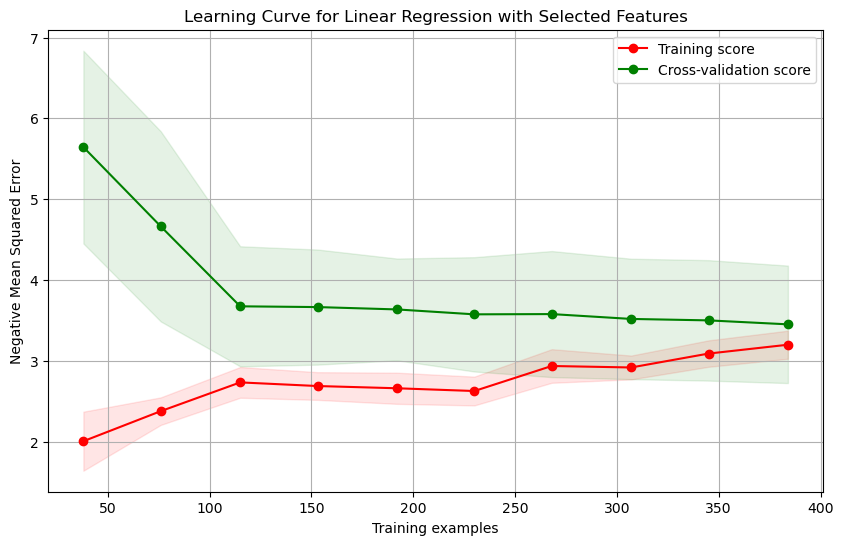

In [55]:
# learning curve 계산
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    lr_model, X_train_selected_lr, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), return_times=True
)

# 성능 지표 계산
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Negative Mean Squared Error')
plt.title('Learning Curve for Linear Regression with Selected Features')
plt.legend(loc="best")
plt.grid()
plt.show()

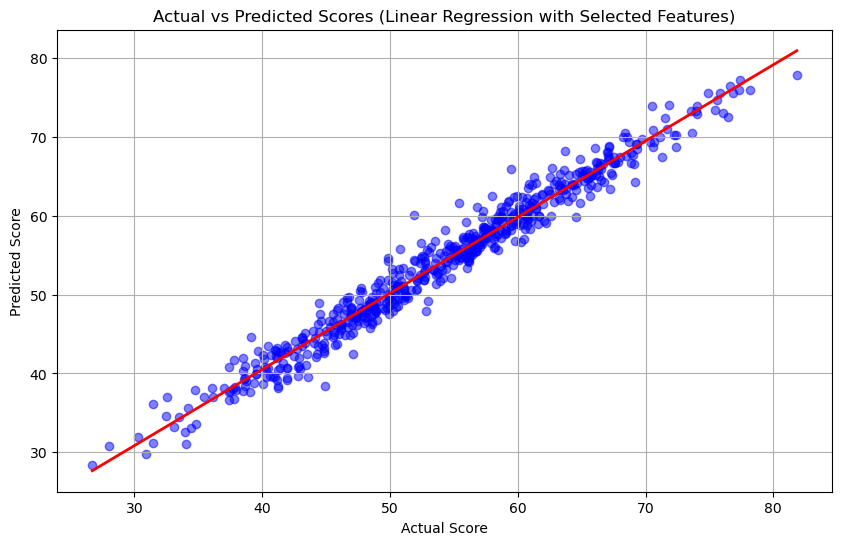

In [59]:
# 예측값 계산
y_train_pred = lr_model.predict(X_train_selected_lr)
y_test_pred = lr_model.predict(X_test_selected_lr)

# 훈련 데이터와 테스트 데이터를 합친 전체 데이터셋
X_combined = np.vstack((X_train_selected_lr, X_test_selected_lr))
y_combined = np.concatenate((y_train, y_test))
y_combined_pred = np.concatenate((y_train_pred, y_test_pred))

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_combined, y_combined_pred, color='blue', alpha=0.5)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Scores (Linear Regression with Selected Features)')
plt.grid(True)

# 회귀선 그리기
# y = mx + c 형태의 직선의 기울기(m)와 절편(c)을 계산합니다.
m, c = np.polyfit(y_combined, y_combined_pred, 1)
x_range = np.linspace(min(y_combined), max(y_combined), 100)
y_range_pred = m * x_range + c
plt.plot(x_range, y_range_pred, color='red', linewidth=2)

plt.show()

---

## 02-2 최적의 하이퍼파라미터 튜닝 후 성능 결과

In [60]:
model_result = pd.DataFrame({
    'MSE': [dt_mse, rf_mse, knn_mse, xgb_mse, ada_mse, lgb_mse, gbr_mse, lr_mse],
    'MAE': [dt_mae, rf_mae, knn_mae, xgb_mae, ada_mae, lgb_mae, gbr_mae, lr_mae],
    'R2': [dt_r2, rf_r2, knn_r2, xgb_r2, ada_r2, lgb_r2, gbr_r2, lr_r2]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor', 'LinearRegression'])
print(model_result)

                                MSE       MAE        R2
DecisionTreeRegressor      9.996459  2.329254  0.884604
RandomForestRegressor      4.012175  1.503386  0.953685
KNeighborsRegressor        4.439314  1.621496  0.948754
XGBoostRegressor           3.346868  1.394755  0.961365
AdaBoostRegressor          5.979412  1.927519  0.930976
LightGBMRegressor          3.549552  1.431449  0.959025
GradientBoostingRegressor  3.053318  1.335346  0.964754
LinearRegression           2.788191  1.302658  0.967814


In [61]:
# prompt: 제일 좋은 성능 두가지
print("MSE 기준")
print(model_result.sort_values(by=['MSE'], ascending=True).head(3))
print(" ")

print("MAE 기준")
print(model_result.sort_values(by=['MAE'], ascending=True).head(3))
print(" ")

print("R2 기준")
print(model_result.sort_values(by=['R2'], ascending=False).head(3))

MSE 기준
                                MSE       MAE        R2
LinearRegression           2.788191  1.302658  0.967814
GradientBoostingRegressor  3.053318  1.335346  0.964754
XGBoostRegressor           3.346868  1.394755  0.961365
 
MAE 기준
                                MSE       MAE        R2
LinearRegression           2.788191  1.302658  0.967814
GradientBoostingRegressor  3.053318  1.335346  0.964754
XGBoostRegressor           3.346868  1.394755  0.961365
 
R2 기준
                                MSE       MAE        R2
LinearRegression           2.788191  1.302658  0.967814
GradientBoostingRegressor  3.053318  1.335346  0.964754
XGBoostRegressor           3.346868  1.394755  0.961365


---